In [602]:
#load libraries
import math
import numpy as np
import warnings
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import zoom

from scipy import interpolate
from functools import partial

def load_object(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# UTILITY

In [603]:

def doust_corr(beta, n):
    '''
    create nxn doust correlation with beta decay exponential
    n = # of semi-annual expiries
    '''
    tau = np.arange(0, n+1)/2 # start from spot
    a = np.exp(- beta / np.arange(1, len(tau[:-1])+1) )
    doust = np.zeros((n, n))
    dim = doust.shape
    for i in range(doust.shape[0]):
        for j in range(doust.shape[1]):
            if i == j:
                doust[i, j] = 1
            elif i > j:
                doust[i, j] = np.prod(a[j:i])
    #reflect
    doust[np.triu_indices(dim[0], 1)] = doust.T[np.triu_indices(dim[0], 1)]
    return(doust)


def interpolate_correlation_matrix(matrix: np.ndarray, resolution: int) -> np.ndarray:
    """
    Interpolates a correlation matrix using bilinear interpolation.

    Args:
        matrix (np.ndarray): The input correlation matrix (must be square).
        resolution (int): The resolution factor. For a 4x4 and resolution=2, output will be 7x7.

    Returns:
        np.ndarray: Interpolated correlation matrix.
    """
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Input must be a square matrix.")

    # Compute zoom factor: new_size = original_size + (original_size - 1) * (resolution - 1)
    zoom_factor = resolution

    # Use order=1 for bilinear interpolation
    interpolated = zoom(matrix, zoom=zoom_factor, order=1)

    # Adjust shape to match expected output: new size = original + (n-1)*(res-1)
    target_size = matrix.shape[0] + (matrix.shape[0] - 1) * (resolution - 1)
    interpolated = interpolated[:target_size, :target_size]

    return interpolated



def get_instant_vol_func(tau , params):
    '''
    Return the instantaneous volatility ,
    computed in terms of the parametric
    form proposed by Rebonato , at a given time t.
    @var t: time at which we want to compute the
    instantaneous volatility (in years)
    @var expiry: caplet expiry (in years)
    @var a: parameter a of Rebonato ’s instant. vol. function
    @var b: parameter b of Rebonato ’s instant. vol. function
    @var c: parameter c of Rebonato ’s instant. vol. function
    @var d: parameter d of Rebonato ’s instant. vol. function
    
    #g(T - t) & h(T - t)
    '''
    tau = np.maximum(tau, 0)
    a,b,c,d = params
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol

# DATA LOADING AND CLEANING

In [604]:
path_params = os.path.join(os.getcwd(), "parameters")
forwards = load_object(path_params+"/spot_forwards.pkl")
s0_exp = load_object(path_params+"/vol_initial_correction.pkl")
epsilon_exp = load_object(path_params+"/volvol_initial_correction.pkl")
doust_fwd_fwd = load_object(path_params+"/fwdfwd_corr.pkl")
doust_vol_vol = load_object(path_params+"/volvol_corr.pkl")
corr_fwd_vol = load_object(path_params+"/fwdvol_corr.pkl")
params_g = load_object(path_params+"/vol_params_g.pkl")
params_h= load_object(path_params+"/volvol_params_h.pkl")
spots= load_object(path_params+"/spot_rates.pkl")
params_g = np.array([-0.00557585, -0.00864318,  0.89466108,  0.00755986])
params_h = np.array([1.42258187e-08, 3.01935702e01, 4.57201647e00, 4.05843346e-12,])
epsilon_exp = np.concatenate([epsilon_exp[[0]],epsilon_exp])
s0_exp = np.concatenate([s0_exp[[0]], s0_exp])



rho_mat_6m = doust_fwd_fwd[:19, :19]
theta_mat_6m = doust_vol_vol[:19, :19] #TODO: check if this is correct, or it should remove the first row and column instead
phi_mat = corr_fwd_vol
fwd_tenors = np.arange(1,10.5,0.5)
# self defined
params_g = np.array([0.005, 0.04, 1, 0.001])
params_h = np.array([0.001, 3, 3, 0.01])
s0_exp = np.ones_like(s0_exp)


# Create new matrices 


beta_6m = 0.20696204
beta_0m = 0.25697769
beta_theta_0m = 0.1556888
beta_theta_6m = 0.12135651
n=20
tau = np.arange(0, n+1)/2



rho_mat_0m = doust_corr(beta_0m, n)
theta_mat_0m = doust_corr(beta_theta_0m, n)
# SHOULD BE IN LMM CLASS
rho_mat_0m_interpolated = interpolate_correlation_matrix(rho_mat_0m, resolution)
theta_mat_0m_interpolated = interpolate_correlation_matrix(theta_mat_0m, resolution)


# create rates 
path = os.path.join(os.getcwd(), "raw_dataset")
df_cap = pd.read_excel(path+"/caplet_raw.xlsx", sheet_name = 2, header = 0)
df_raw_spot = pd.read_csv(path+"/spot.csv")
df_raw_spot["Tenor"] = np.array([1/12, 2/12, 3/12, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 20, 30, 50])


# LMMSABR RELATED FUNCS

In [ ]:





def create_df_init(df_cap, df_raw_spot, resolution, tau=0.5):

    # Get the LIBOR 6-month spot rate
    libor_6m_spot = df_raw_spot.loc[df_raw_spot["Tenor"] == 0.5, "Spot"].iloc[0] # floating point comparison only safe due to 0.5 bein representable with 2**-1

    # Create a dataframe with the initial values for the spot rate
    spot_row = pd.DataFrame({
        'Fixing': [0.0],
        'Reset Rate': [libor_6m_spot],  # Convert back to percentage
        'Maturity': [0.5]
    })

    # Initialize df_init with df_cap data
    df_full = df_cap[['Fixing', 'Reset Rate', 'Maturity']].copy()

    # Concatenate with the spot rate row and reset index
    df_full = pd.concat([spot_row, df_full], ignore_index=True)
    df_full['Reset Rate'] = df_full['Reset Rate'] / 100  # Convert to percentage


    # =============================================================================
    #                               TIME INDEXING
    # =============================================================================
    ts_fwd_expiry = df_full['Fixing'].values

    dt = tau / resolution
    ids_fwd_interp = (ts_fwd_expiry / dt).astype(int) # divide by dt to get indices in the new time unit
    
    
    n_fwd = len(ts_fwd_expiry)-1 # exclude period covering the last forward rate tenor
    ts_fwd_interp= np.linspace(0, n_fwd*tau, int(n_fwd * resolution +1))
    #print(f"{ts_fwd_interp=}")
    assert np.all(np.isin(ts_fwd_expiry, ts_fwd_interp)), "Not all forward expirys are in the time grid"
    # =============================================================================




    # =============================================================================
    #           Create the zcb interpolated curve
    # =============================================================================


    fwd_canon = df_full['Reset Rate'].values
    discount_factors = 1 / (1 + fwd_canon[:-1] * 0.5) # leave out last as we dont use zcb prices after the last forward rate
    zcb_from_fwd = np.concatenate(([1], np.cumprod(discount_factors)))

    zcb_cs = interpolate.CubicSpline(ts_fwd_expiry, zcb_from_fwd)
    zcb_interp = zcb_cs(ts_fwd_interp)

    # =============================================================================


    # =============================================================================
    #          Construct dataframe with tenors, zcb and forward rates
    # =============================================================================
    df = pd.DataFrame({'Tenor': ts_fwd_interp, 'zcb': zcb_interp, 'Forward': np.nan, 's0': np.nan})
    df.loc[ids_fwd_interp, 'Forward'] = fwd_canon
    df.loc[ids_fwd_interp, 'k0'] = s0_exp
    # add column with backfilled forward indices, such that the value in this column is 0 from 0 to 5, 1 from 6 to 11, 2 from 12 to 17, etc.    
    df['i_s'] = (np.arange(len(df)) // resolution)*resolution
    df['i_sp1'] = (np.arange(len(df)) // resolution+1)*resolution
    df['mod_accrual'] = tau - (df['Tenor'] % tau)
    df_temp = df.merge(
    df[['zcb', 'Forward']],
    left_on='i_s',     # Column with pointers to index
    right_index=True,      # Use index from right DataFrame
    how='left',            # Keep all rows from original
    suffixes=('', '_i_s')  # Add suffix to avoid column name conflicts
    )
    df_temp = df_temp.merge(
    df[['zcb']],
    left_on='i_sp1',     # Column with pointers to index
    right_index=True,      # Use index from right DataFrame
    how='left',            # Keep all rows from original
    suffixes=('', '_i_sp1')  # Add suffix to avoid column name conflicts
    )
    df['gamma']= (df_temp['zcb'] / df_temp['zcb_i_sp1'] -1) / df_temp['mod_accrual'] /df_temp['Forward_i_s']


    # =============================================================================
    return df


def interp_func_fac(df_init, resolution=2, tau=0.5, beta=0.5, rho_mat=None, g_func=None, interp_vol = False):
    df = df_init
    #fwd = df['Forward'].values # only used for test, not to be uncommented

    i_s = df['i_s'].values[:-resolution]
    i_sp1 = df['i_sp1'].values[:-resolution]
    i_e = i_sp1

    s = np.arange(len(df)-resolution)
    #print("len s",len(s))
    e = s + resolution

    theta = (df['mod_accrual'].values)
    gamma = (df['gamma'].values)
    gamma_theta = gamma * theta

    #print(f"{len(i_s)}, {len(i_e)}")
        



    def get_interp_rates(fwd):
        p_s_e = (1 + fwd[i_e] * gamma_theta[e]) / (1 + fwd[i_s] * gamma_theta[s]) * 1/(1+fwd[i_e]*tau)
        f_s_e = (1 / p_s_e - 1) / tau 
        return f_s_e
    
    if interp_vol:
        rho_mat_interpolated = interpolate_correlation_matrix(rho_mat, resolution)
        fwd = df['Forward'].values
        f1 = fwd[i_s]**beta      
        f2 = fwd[i_e]**beta
        w1 = gamma_theta[s] / tau
        w2 = (tau - gamma_theta[e]) / tau
        f_interp = get_interp_rates(fwd)**beta
        term1 = (w1**2) * (f1**2)/f_interp[s]**2
        term2 = (w2**2) * (f2**2)/f_interp[s]**2
        rho = rho_mat_interpolated[i_s, i_e]  
        cross = 2 * w1 * w2 * f1 * f2 * rho / f_interp[s]**2
        tenors = df['Tenor'].values
        ttm_mat = tenors[None,:]-tenors[:,None]
        g_mat = g_func(ttm_mat)
        def get_interp_vol(s_arr,t_idx):
            
            s1 = s_arr[i_s]
            s2 = s_arr[i_e]
            # Compute numerator vectorized
            term1_s = term1 * (s1**2)
            term2_s = term2 * (s2**2)
            cross_s = cross * s1 * s2 
            sigma_sum = term1_s + term2_s + cross_s
            s_interp = np.sqrt(sigma_sum)
            return s_interp / g_mat[t_idx, s]


        return get_interp_rates, get_interp_vol
    
    return get_interp_rates



def get_swap_matrix(f_sim, T_idxs, resolution, tau, tenor, df, expiry=1, beta=0.5, B=0.5):
    """
    Compute time-evolving swap rates from a simulated forward path for a set of swap expiries.

    Parameters:
    - f_sim: np.ndarray, shape (n_steps, n_forwards)
        Simulated forward curve matrix (lower-triangular in time).
    - T_idxs: list or np.ndarray of int
        Forward indices (expiry) at which each swap starts.
    - resolution: int
        Number of simulation steps per accrual period (tau).
    - tau: float
        Accrual period of the swap (e.g., 0.5 for semiannual).
    - tenor: float
        Total length of the swap in years (e.g., 1.0 for a 1y swap).
    - df: pd.DataFrame
        DataFrame containing initial zero-coupon bond prices in column 'zcb'.
    - expiry: float, optional
        If provided, the maximum length of a simulated swap path will be limited to this value (in year units).
    Returns:
    - swap_paths: np.ndarray, shape (n_valid_steps, n_swaps)
        Matrix of swap rates over time for each swap expiry.
    - valid_steps: np.ndarray
        Array of time steps for which all required forward rates exist.
    - used_T_idxs: np.ndarray
        Final T_idxs that were valid and included in the result.
    """
    f_sim = np.asarray(f_sim)
    T_idxs = np.asarray(T_idxs)
    zcbs = df['zcb'].values

    n_steps, n_forwards = f_sim.shape
    n_payments = int(tenor / tau)
    swap_len = n_payments  # number of forward rates needed

    # Compute max usable T_idx based on number of forward rates
    max_T_idx = n_forwards - swap_len * resolution
    T_idxs = T_idxs#[T_idxs <= max_T_idx]
    if len(T_idxs) == 0:
        raise ValueError("No valid T_idxs remain after filtering based on swap length and resolution.")

    # Compute all valid time steps
    t_end = n_steps - swap_len * resolution
    valid_steps = np.arange(0, t_end)

    # Compute forward rate indices for each swap
    forward_offsets = np.arange(n_payments) * resolution
    col_indices = T_idxs[:, None] + forward_offsets[None, :]
    # Check bounds
    if np.any(col_indices >= n_forwards):
        raise IndexError("Computed forward indices exceed available f_sim columns.")

    # Compute ZCB indices needed for annuity weights
    zcb_offsets = np.arange(1,n_payments+1) * resolution
    zcb_indices = T_idxs[:, None] + zcb_offsets[None, :]
    if np.any(zcb_indices >= len(zcbs)):
        raise IndexError("Computed ZCB indices exceed available zcb entries.")
    

    # Compute frozen swap weights
    zcb_sets = np.stack([zcbs[idxs] for idxs in zcb_indices])
    swap_weights = zcb_sets * tau
    swap_weights = swap_weights / swap_weights.sum(axis=1, keepdims=True)

    # Gather simulated forward rate and volatility slices
    f_curves = f_sim[valid_steps]
    fwd_subsets = np.stack([f_curves[:, idxs] for idxs in col_indices], axis=1)

    #print(fwd_subsets.shape)
    # Compute weighted sum (dot product): (n_valid_steps, n_swaps)
    swap_paths = np.einsum('tsp,sp->ts', fwd_subsets, swap_weights)
    swap_paths[np.triu_indices_from(swap_paths, k=int(expiry*resolution/tau+1))] = np.nan  # Set upper triangle to NaN

    # Compute W: (n_valid_steps, n_swaps, n_payments)
    swaps_expanded = swap_paths[:, :, None]  # (n_valid_steps, n_swaps, 1)
    W = swap_weights[None, :, :] * (fwd_subsets**beta) / (swaps_expanded**B)  # default: beta=0.5, B=0.5
    #print(swap_weights)
    #W = np.nan_to_num(W)
    return swap_paths, W


def make_swap_indexer(n_steps, T_idxs, resolution, tau, tenor, return_indices=False):
    """
    this is a function factory to create an indexer that given a matrix of similar structure to f_sim
    will return an indexer function that takes a matrix of simulated values connected to a set of values relevant to the swap

    Parameters:
    - n_steps: int
        Number of simulation steps.
    - T_idxs: np.ndarray
        Array of forward indices where swaps start (e.g. expiries).
    - resolution: int
        Number of simulation steps per accrual period (tau).
    - tau: float
        Accrual period of the swap (e.g., 0.5 for semiannual).
    - tenor: float
        Total length of the swap in years (e.g., 1.0 for a 1y swap).
    - return_indices: bool, optional
        If True, return the valid steps and column indices used for indexing.
    Returns:
    - indexer: callable
        Function to index into the matrix of simulated forward rates.
    - (valid_steps, col_indices): tuple of np.ndarray
        If return_indices is True, returns the valid steps and column indices used for indexing.
    """
    n_payments = int(tenor / tau)
    swap_len = n_payments
    t_end = n_steps - swap_len * resolution
    valid_steps = np.arange(0, t_end)
    offsets = np.arange(n_payments) * resolution
    col_indices = T_idxs[:, None] + offsets[None, :]
    col_indices = np.broadcast_to(col_indices, (len(valid_steps), *col_indices.shape))

    def indexer(mat):
        mat_short = mat[valid_steps]
        mat_short = mat_short[:, None, :]
        return np.take_along_axis(mat_short, col_indices, axis=2) # shape (n_valid_steps, n_swaps, n_payments)
    if return_indices:
        return indexer, (valid_steps, col_indices)
    return indexer 



,Tenor,zcb,Forward,s0,k0,i_s,i_sp1,mod_accrual,gamma
0,0.000000,1.000000,0.002318,NaN,1.0,0,3,0.500000,1.000000
1,0.166667,0.999602,NaN,NaN,NaN,0,3,0.333333,0.984890
2,0.333333,0.999220,NaN,NaN,NaN,0,3,0.166667,0.979400
3,0.500000,0.998842,0.002445,NaN,1.0,3,6,0.500000,1.000000
4,0.666667,0.998458,NaN,NaN,NaN,3,6,0.333333,1.026744
5,0.833333,0.998055,NaN,NaN,NaN,3,6,0.166667,1.062617
6,1.000000,0.997623,0.002898,NaN,1.0,6,9,0.500000,1.000000
7,1.166667,0.997156,NaN,NaN,NaN,6,9,0.333333,1.014569
8,1.333333,0.996668,NaN,NaN,NaN,6,9,0.166667,1.015482
9,1.500000,0.996179,0.003086,NaN,1.0,9,12,0.500000,1.000000


In [ ]:
# Rewriting the function with corrected forward index logic (based on tenor, tau, resolution)


# Parameters from user-provided setup
tau = 0.5
resolution = 2
tenor = 1

times = np.arange(0, 8.0001, tau / resolution)
#print(times.shape)
n_steps = len(times)
f_sim = np.tile(np.linspace(0.01, 0.04, n_steps), (n_steps, 1))
f_sim[np.tril_indices_from(f_sim, k=-1)] = np.nan
df = pd.DataFrame({'zcb': np.exp(-0.02 * times)})
T_idxs = np.arange(10)


# Run the final version
swap_paths, W = get_swap_matrix(
    f_sim, T_idxs, resolution, tau, tenor, df, beta=0.5, B=0.5
)
#print(swap_paths.shape)
# Display result
col_names = [f"Swap_{times[i]:.2f}y" for i in T_idxs]
df_result = pd.DataFrame(swap_paths, index=np.arange(len(swap_paths)), columns=col_names)
df_result


,Swap_0.00y,Swap_0.25y,Swap_0.50y,Swap_0.75y,Swap_1.00y,Swap_1.25y,Swap_1.50y,Swap_1.75y,Swap_2.00y,Swap_2.25y
0,0.010933,0.01187,0.012808,0.013745,0.014683,NaN,NaN,NaN,NaN,NaN
1,NaN,0.01187,0.012808,0.013745,0.014683,0.01562,NaN,NaN,NaN,NaN
2,NaN,NaN,0.012808,0.013745,0.014683,0.01562,0.016558,NaN,NaN,NaN
3,NaN,NaN,NaN,0.013745,0.014683,0.01562,0.016558,0.017495,NaN,NaN
4,NaN,NaN,NaN,NaN,0.014683,0.01562,0.016558,0.017495,0.018433,NaN
5,NaN,NaN,NaN,NaN,NaN,0.01562,0.016558,0.017495,0.018433,0.01937
6,NaN,NaN,NaN,NaN,NaN,NaN,0.016558,0.017495,0.018433,0.01937
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017495,0.018433,0.01937
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018433,0.01937
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01937


In [473]:
def get_W_frozen(resolution, tau, df, tenor=1,beta=0.5, B=0.5):
    zcbs =df['zcb'].values # returns 2y swap rate
    interp_fac = interp_func_fac(df_init, resolution=resolution, tau=tau)
    fwd = interp_fac(df['Forward'].values)# start by having a "hole" in the forward rates to check alignment
    fwd_sw = np.lib.stride_tricks.sliding_window_view(fwd, window_shape=int(resolution*tenor/tau))[:,::resolution]

    # shift the swap rates since the zcb points to the end of the forward rate period
    swap_weights = np.lib.stride_tricks.sliding_window_view(zcbs, window_shape=int(resolution*tenor/tau))[resolution:,::resolution]*tau
    
    
    swap_weights = swap_weights/swap_weights.sum(axis=1)[:, np.newaxis]
    swaps = np.sum(swap_weights * fwd_sw, axis=1)
    W = swap_weights*(fwd_sw**beta) / swaps[:, np.newaxis]**B
    return W



    



get_W_frozen(2, 0.5, df_init, tenor=1)

array([[0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.5  , 0.5  ],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.679, 0.198],
       [0.679, 0.198],
       [0.197, 0.679],
       [0.196, 0.679],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.498, 0.502],
       [0.679, 0.199],
       [0.678, 0.199],
       [0.197, 0.679],
       [0.197, 0.679],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.499, 0.501],
       [0.4

In [474]:
#def get_W_frozen():
swap_rate_func(0,1, df_init['Forward'].values)

nan

In [475]:


class LMMSABR():
    def __init__(self, rho_mat, theta_mat, phi_mat, g_params, h_params, epsilon_exp, k0_exp, yell=True):
        self.rho_mat = rho_mat
        self.theta_mat = theta_mat
        self.phi_mat = phi_mat
        self.g = partial(get_instant_vol_func, params=g_params)
        self.h = partial(get_instant_vol_func, params=h_params)
        self.epsilon_exp = epsilon_exp
        self.k0_exp = k0_exp
        if yell:
            print("h SHOULD PERHAPS BE FORCED TO BE POSITIVE")
    
    def creat_df_fwd_init(self):
        pass


    @staticmethod
    def getInstantaneousVolatility(t, expiry , params):
        '''
        Return the instantaneous volatility ,
        computed in terms of the parametric
        form proposed by Rebonato , at a given time t.
        @var t: time at which we want to compute the
        instantaneous volatility (in years)
        @var expiry: caplet expiry (in years)
        @var a: parameter a of Rebonato ’s instant. vol. function
        @var b: parameter b of Rebonato ’s instant. vol. function
        @var c: parameter c of Rebonato ’s instant. vol. function
        @var d: parameter d of Rebonato ’s instant. vol. function
        
        #g(T - t) & h(T - t)
        '''
        a,b,c,d = params
        tau = expiry - t
        instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
        return instantaneous_vol
    

    def zcb_price(self, t, T,S, forwards):
        pass

    def get_fwd_drift(self, t, f_t: np.ndarray):
        """find the drift of the forward rate given all longer maturity forwards"""
        pass
    def get_vol_drift(self, t, f_t):
        pass

    def simulate(self,resolution,max_expiry=9.5,  tau=0.5,hedge_expiry=1, hedged_expiry=2, tenor=1):
        df_init = create_df_init(df_cap, df_raw_spot, resolution=resolution, tau=tau).query(f"Tenor <= {max_expiry+1e-6}")

        ids_fwd_canon = df_init['Forward'].dropna().index.values
        num_sim = len(df_init)-1
        f_0 = df_init['Forward'].values
        num_forwards = df_init['Forward'].dropna().shape[0]
        tenors = df_init['Tenor'].values
        
        swap_tenor = tenor
        interp_func, interp_vol_func = interp_func_fac(df_init, resolution=resolution, tau=tau, rho_mat=self.rho_mat, g_func=self.g, interp_vol=True)

        self.tenors = tenors
        self.num_sim = num_sim+1
        self.resolution = resolution




        dt = tau / resolution
        self.dt = dt
        #print(f"times per year = {resolution*tau}")
        dt_sqrt = math.sqrt(dt)
        self.t_arr = tenors
        ttm_mat = tenors[None,:]-tenors[:,None] # each row is a time increment, and each column represents the time to maturity of a forward rate
        f_sim = np.zeros(ttm_mat.shape)*np.nan # each simulation, we must have a spot rate



        ids_all = df_init.index.values
        # precompute h and g
        #ttm_mat = tenors - t_arr.reshape(-1,1)
        #ttm_mat# [ttm_mat<0] = 0 # TODO: ENABLE THIS IF IT GOES WRONG
        h_mat = self.h(ttm_mat[1:, ids_fwd_canon])
        g_mat = self.g(ttm_mat[:, ids_fwd_canon])

        self.g_mat = g_mat
        self.h_mat = h_mat
        self.ttm_mat = ttm_mat
        # precompute random draws
        dZ_f = np.random.multivariate_normal(np.zeros(num_forwards), self.rho_mat[:num_forwards,:num_forwards], num_sim) * dt_sqrt
        dW_s = np.random.multivariate_normal(np.zeros(num_forwards), self.theta_mat[:num_forwards,:num_forwards], num_sim) * dt_sqrt

        k_mat = np.concatenate([self.k0_exp[:num_forwards].reshape(1,-1), (self.k0_exp[:num_forwards] * np.cumprod(1 + self.epsilon_exp[:num_forwards].reshape(1,-1) * dW_s * h_mat, axis=0))])

        s_mat = g_mat * k_mat
        self.s_mat = s_mat

        
        k_mat_full_res = np.zeros((num_sim+1, num_sim+1))*np.nan
        s_mat_full_res = np.zeros((num_sim+1, num_sim+1))*np.nan
        
        s_mat_full_res[:, ids_fwd_canon] = k_mat * g_mat

        for i in range(num_sim+1):
            k_mat_full_res[i,:-resolution] = interp_vol_func(s_mat_full_res[i], t_idx=i)
            if i >= resolution:
                k_mat_full_res[i, :(i-resolution)] = np.nan
        
        self.k_mat_full_res = k_mat_full_res
        self.k_mat = k_mat

        drift_correction = np.zeros(len(f_sim[0]))
        drift_shared = np.zeros(len(f_sim[0]))
        ids_fwd_canon_rev = ids_fwd_canon[::-1]


        
        ids_fwd_canon_short_rev = ids_fwd_canon_rev//resolution
        non_canon_indices = np.setdiff1d(np.arange(len(f_sim[0]))[:-resolution], ids_fwd_canon_rev)
        non_canon_idx = non_canon_indices
        f_list = []
        


        

        for i in range(1):
            f_sim = f_sim * np.nan
            f_sim[0] = f_0*4
            f_sim[0, non_canon_idx] = interp_func(f_sim[0])[non_canon_idx]

            for t in range(1, num_sim):
                drift_correction.fill(0)
                drift_shared.fill(0)
                # next loop runs from longest to shortest tenor
                for canon_short_idx, canon_idx in zip(ids_fwd_canon_short_rev, ids_fwd_canon_rev):
                    
                    if ttm_mat[t, canon_idx] +tau+1e-8>= 0:     # TODO <------------ THIS IS IMPORTANT
                        s_t, dZ_f_t,  f_t = s_mat[t-1, canon_short_idx], dZ_f[t-1,canon_short_idx], f_sim[t-1,canon_idx]
                        f_beta_t = f_t**0.5
                        
                        drift_f = (-g_mat[t, canon_short_idx] * k_mat[t, canon_short_idx] * f_beta_t * drift_shared[canon_short_idx])
                        df_t =  drift_f + f_beta_t*s_t*dZ_f_t
                        f_t += df_t
                        
                        f_t_new =  f_t + df_t if f_t + df_t > 0 else 0  # zero absorbing boundary, interest rates cannot be negative due to arbitrage
                        f_sim[t,canon_idx] = f_t_new

                        if canon_short_idx > 0:
                            drift_correction[canon_short_idx-1] = self.rho_mat[canon_short_idx-1, canon_short_idx] * tau * g_mat[t,canon_short_idx] * k_mat[t, canon_short_idx] * f_beta_t / (1 + tau * f_t)
                            drift_shared[canon_short_idx-1] = np.sum(drift_correction[canon_short_idx-1:])
                

                    
                f_sim[t, non_canon_idx] = interp_func(f_sim[t])[non_canon_idx]


            
            self.f_sim = f_sim
            f_list.append(f_sim)
        self.f_list = f_list
        T_idxs = np.arange(len(f_sim)-int(tenor/tau*resolution))
        swap_sim, W = get_swap_matrix(f_sim, T_idxs=T_idxs, resolution=resolution, tau=tau, tenor=swap_tenor, df=df_init)    
        self.W = W
        self.swap_sim = swap_sim
        assert self.k_mat_full_res.shape == self.f_sim.shape, f"Shape mismatch: {self.k_mat_full_res.shape} != {self.f_sim.shape}"
        return f_sim, swap_sim, k_mat_full_res
    


    def plot(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Create mesh grid for x (time) and y (tenors)
        X = np.arange(self.num_sim)*self.dt
        Y = np.arange(self.num_sim-resolution)*self.dt
        X, Y = np.meshgrid(X, Y)
        
        # Transpose f_sim to match the grid shape
        Z = self.f_sim[:,:-resolution].T

        # Create surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        
        # Add labels and colorbar
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Tenors')
        ax.set_zlabel('Forward Rates')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        
        plt.show()
    def plot_swap(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        # Create mesh grid the shape of self.swap_sim
        X = np.arange(self.swap_sim.shape[0])*self.dt
        Y = np.arange(self.swap_sim.shape[1])
        X, Y = np.meshgrid(X, Y)
        Z = self.swap_sim.T
        # Create surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        # Add labels and colorbar
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Swap Expiry')
        ax.set_zlabel('Swap Rates')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        # angle so we look down from above
        ax.view_init(elev=45, azim=210)
        
        plt.show()
lmm = LMMSABR(rho_mat_0m, theta_mat_0m, phi_mat, params_g, params_h, epsilon_exp, k0_exp=s0_exp, yell=False)
f_sim, swap_sim, k_mat_full_res = lmm.simulate(resolution=2, max_expiry = 10, tenor=1)
print(lmm.swap_sim.shape, lmm.f_sim.shape, lmm.k_mat_full_res.shape)

(35, 35) (39, 39) (39, 39)


In [480]:
def build_phi_matrix(T, phi_diag, lambda3, lambda4):
    n = len(T)
    phi = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            Ti, Tj = T[i], T[j]
            phi_ii, phi_jj = phi_diag[i], phi_diag[j]
            A = np.sign(phi_ii) * np.sqrt(abs(phi_ii * phi_jj))
            decay = np.exp(-lambda3 * max(Ti - Tj, 0) - lambda4 * max(Tj - Ti, 0))
            phi[i, j] = A * decay

    return phi
T_arr = np.linspace(0, 9.5, 39)

# interpolate phi diag
phi_diag = np.diag(corr_fwd_vol)

phi_diag = np.concatenate([phi_diag[[0]],phi_diag])
T_phi = np.arange(0,10, 0.5)
interpolate_cubic = interpolate.CubicSpline(T_phi, phi_diag)

phi_interp = interpolate_cubic(T_arr)

phi_mat_0m_interpolated = build_phi_matrix(T_arr, phi_interp, 0.0087931, 0.051319)

In [481]:
def precompute_g_integral_tensor(
    lmm,
    tenor_years,
    accrual_factor,
    expiry_years,
    resolution
):
    """
    Precompute a tensor G[t, i, j] = ∫_{t}^{T} g(T_i - s) * g(T_j - s) ds
    for a swaption with given tenor and expiry, where:
        - t varies over discrete time steps up to expiry, at 'resolution' granularity.
        - i, j index legs of the swap starting at expiry (post-expiry flow).

    Parameters:
        lmm: model with .ttm_mat[0] and .g(t)
        tenor_years: float, e.g., 2 for a 2Y swap
        accrual_factor: float, e.g., 0.5 for semiannual
        expiry_years: float, e.g., 1 for a 1Y expiry
        resolution: int, number of time steps per accrual period (e.g., 6 for monthly steps in 6M accrual)

    Returns:
        G_tensor: ndarray of shape (num_steps, n, n)
    """
    tau = accrual_factor
    n = int(tenor_years / tau)
    num_steps = int((expiry_years / tau) * resolution)

    # T_i and T_j are relative maturities of forward rates starting at expiry
    # Assume we always take them from the 0th row (initial T_i values)
    T_vec = lmm.ttm_mat[0]  # shape (N,)
    swap_indices = np.arange(n)
    T_sub = T_vec[swap_indices]  # maturities used in the swap

    G_tensor = np.zeros((num_steps, n, n))

    for step in range(num_steps):
        t_now = step * (tau / resolution)   # current time relative to 0
        T_upper = expiry_years              # integral always ends at expiry (fixed)

        for i in range(n):
            for j in range(n):
                T_i = T_sub[i]
                T_j = T_sub[j]
                integrand = lambda t: lmm.g(T_i - t) * lmm.g(T_j - t)
                integral, _ = quad(integrand, t_now, T_upper)
                G_tensor[step, i, j] = integral

    return G_tensor



In [484]:
class SABR():
    def __init__(self, sigma_0, beta, rho, volvol, K, r, q):
        self.sigma_0 = sigma_0
        self.beta = beta
        self.rho = rho
        self.volvol = volvol
        self.K = K
        self.r = r
        self.q = q

    def get_implied_vol(self, tt, price):
        """Convert SABR instantaneous vol to option implied vol

        Args:
            tt (np.ndarray): time to maturity in shape (num_period,)
            price (np.ndarray): underlying stock price in shape (num_path, num_period)

        Returns:
            np.ndarray: implied vol in shape (num_path, num_period)
        """
        return self._sabr_implied_vol(self.sigma_0 * np.ones_like(price), tt, price)
    def _sabr_implied_vol(self, vol, tt, price):
            """Convert SABR instantaneous vol to option implied vol

            Args:
                vol (np.ndarray): SABR instantaneous vol in shape (num_path, num_period)
                tt (np.ndarray): time to maturity in shape (num_period,)
                price (np.ndarray): underlying stock price in shape (num_path, num_period)

            Returns:
                np.ndarray: implied vol in shape (num_path, num_period)
            """
            F = price * np.exp((self.r - self.q) * tt)
            x = (F * self.K) ** ((1 - self.beta) / 2)
            y = (1 - self.beta) * np.log(F / self.K)
            A = vol / (x * (1 + y * y / 24 + y * y * y * y / 1920))
            B = 1 + tt * (
                    ((1 - self.beta) ** 2) * (vol * vol) / (24 * x * x)
                    + self.rho * self.beta * self.volvol * vol / (4 * x)
                    + self.volvol * self.volvol * (2 - 3 * self.rho * self.rho) / 24
            )
            Phi = (self.volvol * x / vol) * np.log(F / self.K)
            # print("CHI INTERNAL")
            # print((np.sqrt(1 - 2 * self.rho * Phi + Phi * Phi) + Phi - self.rho) / (1 - self.rho))
            Chi = np.log((np.sqrt(1 - 2 * self.rho * Phi + Phi * Phi) + Phi - self.rho) / (1 - self.rho))
            # print("JUST CHI")
            # print(Chi)
            Chi = Chi

            epsilon = 1e-12

            # if abs(F - self.K) < epsilon:
            #     # ATM case — guard against F being 0
            #     safe_F = max(F, epsilon)
            #     SABRIV = vol * B / (safe_F ** (1 - self.beta))
            # else:
            #     # non-ATM case — guard against Chi being too small
            #     safe_Chi = Chi if abs(Chi) > epsilon else epsilon
            #     SABRIV = A * B * Phi / safe_Chi
            SABRIV = np.where(np.isclose(F, self.K), vol * B / (F ** (1 - self.beta)), A * B * Phi / Chi)

            return SABRIV

In [485]:
import numpy as np
from scipy.stats import norm

def black_price(F, K, sigma, T, r=0.0, option_type="call"):
    """
    Black's formula for European options on forwards.

    Args:
        F (float): Forward rate
        K (float): Strike
        sigma (float): Implied volatility
        T (float): Time to maturity
        r (float): Discount rate (e.g. risk-free rate)
        option_type (str): 'call' or 'put'

    Returns:
        float: Present value of the option
    """
    print("T AND SIGMA",T, sigma)
    if np.isclose(T,0) or np.isclose(sigma,0):
        print("WE AT MATURITY")
        intrinsic = max(F - K, 0) if option_type == "call" else max(K - F, 0)
        return np.exp(-r * T) * intrinsic

    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif option_type == "put":
        price = np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price


In [486]:
def precompute_g_integral_tensor_vec(
    lmm,
    tenor_years,
    accrual_factor,
    expiry_years,
    resolution,
    g_grid_points=100  # resolution of the s-integral grid
):
    """294953 
    Fully vectorized precomputation of G[t, i, j] = ∫_t^T g(T_i - s) * g(T_j - s) ds
    using NumPy broadcasting and einsum.
    """
    tau = accrual_factor
    n = int(tenor_years / tau)
    num_steps = int((expiry_years / tau) * resolution)

    # Time-to-maturities of forward rates
    T_vec = lmm.ttm_mat[0]
    T_sub = T_vec[:n]  # (n,)

    # Integration grid over s ∈ [0, expiry]
    #g_grid_points = 2 * num_steps + 1
    s_grid = np.linspace(0, expiry_years, g_grid_points)  # (S,)
    ds = s_grid[1] - s_grid[0]

    # Compute g(T_i - s) for all i, s
    T_mat = T_sub[:, None]  # (n, 1)
    S_mat = s_grid[None, :]  # (1, S)
    g_matrix = lmm.g(T_mat - S_mat)  # shape (n, S)

    # Vectorized outer product of g_matrix over (i,j) per s:
    # g_outer[s, i, j] = g[i, s] * g[j, s]
    g_outer = np.einsum('is,js->sij', g_matrix, g_matrix)  # (S, n, n)

    # Now build G_tensor[t, i, j] by integrating over s ≥ t_k
    G_tensor = np.zeros((num_steps, n, n))

    for step in range(num_steps):
        t_k = step * (tau / resolution)
        s_mask = s_grid >= t_k
        g_cut = g_outer[s_mask]     # (s', n, n)
        s_cut = s_grid[s_mask]      # (s',)

        # Integrate over s using trapezoidal rule
        # Result shape: (n, n)
        G_tensor[step] = np.trapz(g_cut, x=s_cut, axis=0)

    return G_tensor  # shape (num_steps, n, n)

In [487]:
def precompute_G_tensor(lmm, tenor, resolution, tau, max_expiry = 1):
    """
    Precompute a G_tensor using memoization and the lmm.t_arr as integration grid.
    Uses:
        G[t_idx, T_idx, i_local, j_local] = ∫ₜᵀ g(T_i - u) * g(T_j - u) du
    with T_i, T_j based on T_idx and forward rate spacing.
    """
    import numpy as np

    t_arr = lmm.t_arr
    num_t = len(t_arr) - int(tenor * resolution / tau)
    n = int(tenor / tau)
    G_tensor = np.zeros((num_t, num_t, n, n))*np.nan
    # set the diagonal of the n,m,k,l tensor to 0
    G_tensor[np.diag_indices(num_t)] = 0

    cache = {}  # (delta_T_idx, delta_i, delta_j) → float
    max_expiry_idx = int(max_expiry * resolution / tau)  # max expiry in steps
    for t_idx in range(num_t):
        for T_idx in range(t_idx, num_t):
            delta_T_idx = T_idx - t_idx
            # check for max expiry
            if delta_T_idx > max_expiry_idx:
                continue
            # Use the actual model time grid for integration
            s_idx_start = t_idx   # strictly > t
            s_idx_end = T_idx + 1    # include T
            u_arr = t_arr[s_idx_start:s_idx_end]
            if len(u_arr) < 1:
                G_tensor[t_idx, T_idx] = np.zeros((n, n))  # no integration needed
                #print("Skipping integration for empty u_arr at indices:", s_idx_start, s_idx_end)
                continue  # skip if no points to integrate over

            start_idx = T_idx
            end_idx = T_idx + n * resolution
            indices = list(range(start_idx, end_idx, resolution))
            if len(indices) != n:
                continue  # incomplete swap

            for i_local, i_global in enumerate(indices):
                for j_local, j_global in enumerate(indices):
                    delta_i = i_global - T_idx
                    delta_j = j_global - T_idx
                    key = (delta_T_idx, delta_i, delta_j)

                    if key not in cache:
                        T_i = t_arr[i_global]
                        T_j = t_arr[j_global]
                        g_i = lmm.g(T_i - u_arr)
                        g_j = lmm.g(T_j - u_arr)
                        cache[key] = np.trapz(g_i * g_j, u_arr)

                    G_tensor[t_idx, T_idx, i_local, j_local] = cache[key]

    return G_tensor




In [488]:
def pairwise_outer(arr):
    """
    Given an array of shape (..., d), return an array of shape (..., d, d),
    where each (...)-indexed vector is expanded to an outer product with itself.

    Parameters:
    - arr: np.ndarray, shape (..., d)

    Returns:
    - out: np.ndarray, shape (..., d, d)
    """
    return arr[..., :, None] * arr[..., None, :]


In [585]:
def build_swap_correlation_tensor(rho, T_idxs, resolution, tau, tenor, n_valid_steps=None):
    """
    Build a (n_valid_steps, n_swaps, n_payments, n_payments) tensor of forward correlations for each swap.

    Parameters:
    - rho: np.ndarray, shape (n_forwards, n_forwards)
        Correlation matrix between forward rates.
    - T_idxs: np.ndarray, shape (n_swaps,)
        Start indices for each swap.
    - resolution: int
        Number of forward steps per tau.
    - tau: float
        Accrual period (in years).
    - tenor: float
        Swap tenor (in years).
    - n_valid_steps: int
        Number of time steps to tile over.

    Returns:
    - rho_tensor: np.ndarray, shape (n_valid_steps, n_swaps, n_payments, n_payments)
    """
    if not n_valid_steps:
        n_valid_steps = len(T_idxs)
    n_swaps = len(T_idxs)
    n_payments = int(tenor / tau)
    rho_subs = np.empty((n_swaps, n_payments, n_payments))

    for i, T_idx in enumerate(T_idxs):
        indices = T_idx + np.arange(n_payments) * resolution
        rho_subs[i] = rho[np.ix_(indices, indices)]

    # Tile over time steps
    rho_tensor = np.tile(rho_subs[None, :, :, :], (n_valid_steps, 1, 1, 1))
    assert rho_tensor.shape[0] == rho_tensor.shape[1], f"Shape mismatch: {rho_tensor.shape[0]} != {rho_tensor.shape[1]}"
    #print(f"rho_tensor shape: {rho_tensor.shape}")
    return rho_tensor


resolution = 2
lmm = LMMSABR(rho_mat_0m, theta_mat_0m, phi_mat, params_g, params_h, epsilon_exp, k0_exp=s0_exp, yell=False)
lmm.simulate(resolution=resolution, max_expiry=10, tenor=1)
G_tensor = precompute_G_tensor(lmm, tenor=1, resolution=resolution, tau=0.5)
swap_idxs = np.arange(lmm.swap_sim.shape[0])
swap_indexer = make_swap_indexer(n_steps = lmm.f_sim.shape[0], T_idxs=swap_idxs,resolution=resolution, tau=0.5, tenor=1,)
k_tensor = swap_indexer(lmm.k_mat_full_res)

rho_mat_0m_interpolated = interpolate_correlation_matrix(rho_mat_0m, resolution=resolution)
rho_tensor = build_swap_correlation_tensor(rho_mat_0m_interpolated, T_idxs=swap_idxs, resolution=resolution, tau=0.5, tenor=1)
k_tensor_prod = pairwise_outer(k_tensor)
W_tensor_prod = pairwise_outer(lmm.W)


k_tensor_prod.shape
# for the m,n,k,l tensor, sum such that we have a m,n tensor
prod = rho_tensor*W_tensor_prod*k_tensor_prod*G_tensor
#print(np.sum(prod, axis=(2,3)))
#print(np.sum(G_tensor, axis=(2,3)))
#print(np.sum(G_tensor, axis=(2,3)))
numerator = np.sum(prod, axis=(2, 3))
denominator = lmm.ttm_mat[np.ix_(swap_idxs, swap_idxs)]
sigma_sq = np.divide(
    numerator,
    denominator,
    out=np.zeros_like(numerator),  # fill result with 0 where denominator == 0
    where=denominator != 0
)
sigma = np.sqrt(sigma_sq)






In [586]:
def build_phi_matrix(T, phi_diag, lambda3, lambda4):
    n = len(T)
    phi = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            Ti, Tj = T[i], T[j]
            phi_ii, phi_jj = phi_diag[i], phi_diag[j]
            A = np.sign(phi_ii) * np.sqrt(abs(phi_ii * phi_jj))
            decay = np.exp(-lambda3 * max(Ti - Tj, 0) - lambda4 * max(Tj - Ti, 0))
            phi[i, j] = A * decay

    return phi


# interpolate phi diag
phi_diag = np.diag(corr_fwd_vol)

phi_diag = np.concatenate([phi_diag[[0]],phi_diag])
T_phi = np.arange(0,10, 0.5)


phi_mat_0m = build_phi_matrix(T_phi, phi_diag, 0.0087931, 0.051319)

phi_mat_0m_interpolated = interpolate_correlation_matrix(phi_mat, resolution=resolution)

In [596]:
def h_ij_vectorized_from_grid(t, u_arr, T_i, T_j, lmm):
    """
    Compute h_ij for each u in u_arr using the lmm.t_arr as the integration grid.
    Uses searchsorted for efficient pre-filtering of integration intervals.
    """
    t_arr = lmm.t_arr
    t_idx = np.searchsorted(t_arr, t, side='left')  # index just after t
    hij_vals = []

    for u in u_arr:
        if u <= t:
            hij_vals.append(0.0)
            continue

        u_idx = np.searchsorted(t_arr, u, side='right')
        s_grid = t_arr[t_idx:u_idx]
        if len(s_grid) == 0:
            hij_vals.append(0.0)
            continue

        h_prod = lmm.h(T_i - s_grid) * lmm.h(T_j - s_grid)
        integral = np.trapz(h_prod, s_grid)
        hij_vals.append(np.sqrt(integral / (u - t)))

    return np.array(hij_vals)


def integral_term_V(t_idx, T_idx, i, j, lmm):
    """
    Compute the integral:
      ∫ₜᵀ g_i(u)*g_j(u)*[h_ij(t,u)]²*(u-t) du
    using lmm.t_arr as the integration grid.
    """
    t = lmm.t_arr[t_idx]
    T = lmm.t_arr[T_idx]
    if T <= t:
        return 0.0

    u_arr = lmm.t_arr[t_idx:T_idx+1]
    dt_arr = u_arr - t
    T_i = lmm.t_arr[i]
    T_j = lmm.t_arr[j]

    h_vals = h_ij_vectorized_from_grid(t, u_arr, T_i, T_j, lmm)
    h_sq = h_vals**2

    g_i_arr = lmm.g(T_i - u_arr)
    g_j_arr = lmm.g(T_j - u_arr)

    integrand = g_i_arr * g_j_arr * h_sq * dt_arr
    return np.trapz(integrand, u_arr)


def build_V_tensor_from_scalar(lmm, tenor, resolution, tau, max_expiry, n_grid=100):
    """
    Build the V_tensor using scalar integral_term_V, memoizing based on
    time-translation invariance.

    Returns:
    - V_tensor: np.ndarray, shape (n_t, n_t, n, n)
    """
    import numpy as np

    n = int(tenor / tau)
    max_expiry_steps = int(max_expiry * resolution / tau)
    num_t = len(lmm.t_arr) - n * resolution
    V_tensor = np.full((num_t, num_t, n, n), np.nan)

    cache = {}  # key: (delta_T, delta_i, delta_j) -> float

    for t_idx in range(num_t):
        expiry_limit = min(t_idx + max_expiry_steps+1, num_t)

        for T_idx in range(t_idx, expiry_limit):
            start_idx = T_idx
            end_idx = T_idx + n * resolution
            indices = list(range(start_idx, end_idx, resolution))

            if len(indices) != n:
                print(f"Skipping incomplete swap at indices: {indices}")
                continue  # Skip incomplete swaps at boundary

            delta_T = T_idx - t_idx

            for i_local, i_global in enumerate(indices):
                for j_local, j_global in enumerate(indices):
                    delta_i = i_global - T_idx
                    delta_j = j_global - T_idx

                    key = (delta_T, delta_i, delta_j)

                    if key not in cache:
                        # Compute and store
                        cache[key] = integral_term_V(
                            t_idx, T_idx, i_global, j_global, lmm
                        )
                    V_tensor[t_idx, T_idx, i_local, j_local] = cache[key]

    return V_tensor


lmm = LMMSABR(rho_mat_0m, theta_mat_0m, phi_mat, params_g, params_h, epsilon_exp, k0_exp=s0_exp, yell=False)
lmm.simulate(resolution=resolution, max_expiry=10, tenor=1)
ggh_tensor = build_V_tensor_from_scalar(lmm, tenor=1, resolution=resolution, tau=0.5, max_expiry=1)




V_terms = rho_tensor*W_tensor_prod*k_tensor_prod*ggh_tensor
phi_mat_0m_interpolated = interpolate_correlation_matrix(phi_mat_0m, resolution=resolution)
phi_tensor = build_swap_correlation_tensor(phi_mat_0m_interpolated, T_idxs=swap_idxs, resolution=resolution, tau=0.5, tenor=1)

V_sum = np.sum(V_terms, axis=(2, 3))

omega_tensor = np.divide(V_terms, V_sum[..., None, None], out=np.zeros_like(V_terms), where=V_sum[..., None, None] != 0)
phi = np.sum(phi_tensor * omega_tensor, axis=(2, 3))


numerator = np.sqrt(2*V_sum)

V = np.divide(
    V_sum,
    sigma*lmm.ttm_mat[np.ix_(swap_idxs, swap_idxs)],
    out=np.zeros_like(numerator),  # fill result with 0 where denominator == 0
    where=denominator != 0
)

#V_sum*100

np.sum(omega_tensor, axis=(2, 3))
phi

array([[ 0.   , -0.345, -0.417, -0.57 , -0.756,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
       [   nan,  0.   , -0.649, -0.635, -0.756, -0.72 ,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
       [   nan,    nan,  0.   , -0.655, -0.756, -0.715, -0.648,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,  0.   , -0.758, -0.706, -0.638, -0.591,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    na

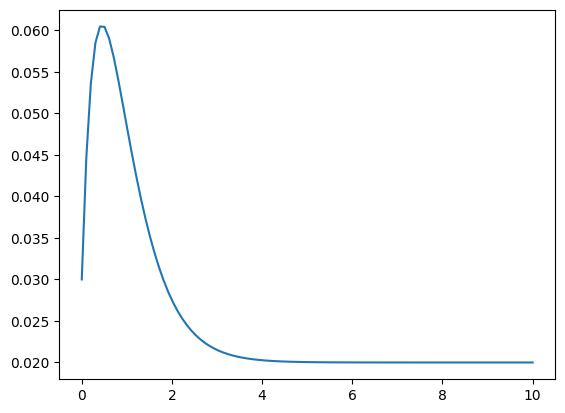

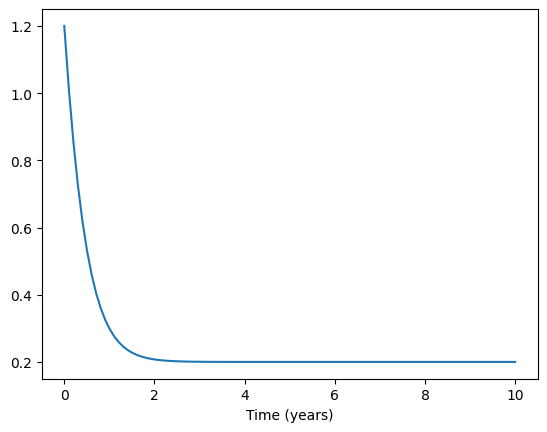

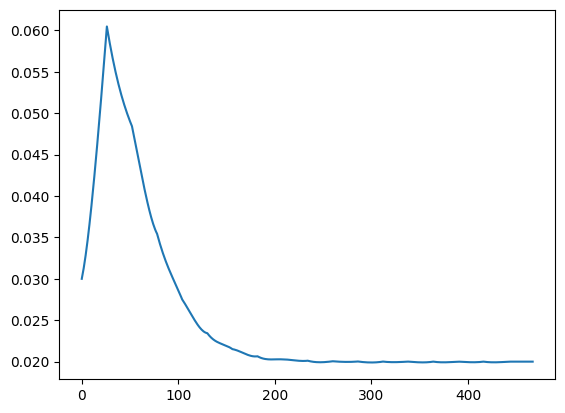

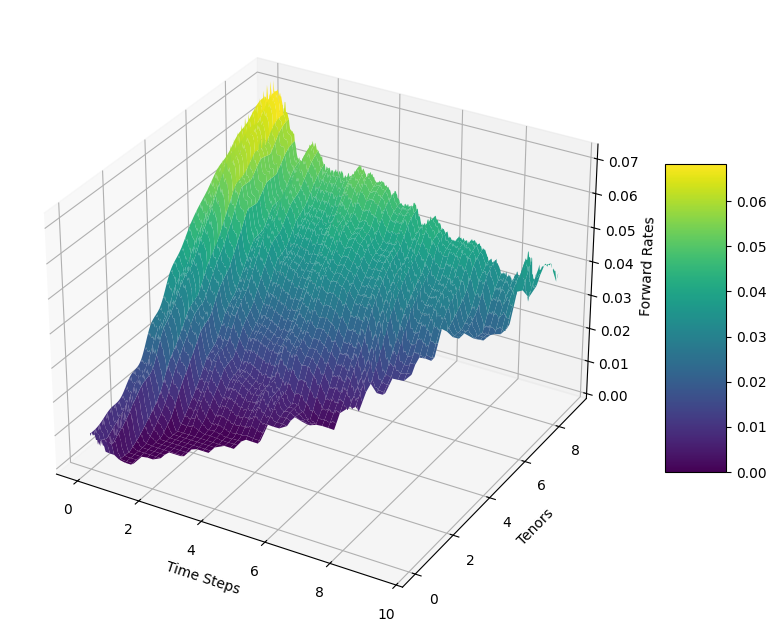

generating g_tensor
done
G TENSOR IN COMPUTE SIGMA0: G_tensor.shape=(443, 443, 2, 2)
Phi in V Phi=-0.7374387286965441
Phi Phi=-0.7374387286965441
ttm=1.0
[t_idx=0] sigma0=0.0500, V=0.3799, beta=0.5, Phi=-0.7374387286965441


AttributeError: 'LMMSABR' object has no attribute 'swap_hedging'

In [ ]:
import numpy as np
from scipy.integrate import quad





def integral_term_g_g(t_idx, T_idx, i, j, lmm, n_grid=100):
    """
    Compute the integral ∫_{t}^{T} g(T_i - u) * g(T_j - u) du
    using time indices and trapezoidal rule.
    """
    t = lmm.t_arr[t_idx]
    T = lmm.t_arr[T_idx]

    if T <= t:
        return 0.0

    u_arr = np.linspace(t, T, n_grid)
    T_i = lmm.t_arr[i]
    T_j = lmm.t_arr[j]

    g_i_arr = lmm.g(T_i - u_arr)
    g_j_arr = lmm.g(T_j - u_arr)

    integrand = g_i_arr * g_j_arr
    integral = np.trapz(integrand, u_arr)

    return integral


def compute_sigma0(k_t, t_idx, T_idx, tenor, resolution, tau, Ws, rho_mat, lmm):
    """
    Compute σ₀ based on the interpolated correlation matrix and weights,
    over the time interval [t, T], given by t_idx and T_idx.
    """
    t = lmm.t_arr[t_idx]
    T = lmm.t_arr[T_idx]
    horizon = T - t
    if horizon <= 0:
        return 0.0

    sigma0_sum = 0.0

    start_idx = int(T * resolution / tau)
    end_idx = int((T + tenor) * resolution / tau)
    local_indices = range(int(tenor * resolution))  # assuming resolution is steps per tau
    iterator = range(start_idx, end_idx, int(resolution))
    print("local indices", int(tenor * resolution), len(Ws[t_idx]))
    for i_w, i in enumerate(iterator):
        for j_w, j in enumerate(iterator):
            #print(f"i_w: {i_w}, j_w: {j_w}, i: {i}, j: {j}, local indices {list(local_indices)}")
            sigma0_sum += (
                rho_mat[i, j] *
                Ws[t_idx, i_w] *
                Ws[t_idx, j_w] *
                k_t[i] *
                k_t[j] *
                integral_term_g_g(t_idx, T_idx, i, j, lmm)
            )
            #print(Ws[t_idx, i_w], Ws[t_idx, j_w], k_t[i], k_t[j], integral_term_g_g(t_idx, T_idx, i, j, lmm))

    sigma0 = np.sqrt((1 / horizon) * sigma0_sum)
    return sigma0


def compute_sigma0_vectorized(k_t, t_idx, T_idx, tenor, resolution, tau, Ws, rho_mat, G_tensor, lmm):
    """
    Vectorized computation of σ₀ using precomputed G_tensor.
    """
    print(f"G TENSOR IN COMPUTE SIGMA0: {G_tensor.shape=}")
    t = lmm.t_arr[t_idx]
    T = lmm.t_arr[T_idx]
    horizon = T - t
    if horizon <= 0:
        return 0.0

    # Determine slice indices
    start_idx = int(T * resolution / tau)
    end_idx = int((T + tenor) * resolution / tau)
    num_steps = end_idx - start_idx
    step_size = int(resolution)  # number of substeps per τ
    num_swap_steps = int(tenor/tau)

    # Build index vector (e.g., [30, 31, ..., 41]) and local swap indices [0, 1, ..., 11]
    indices = np.arange(start_idx, end_idx, step_size)  # shape (n,)
    local_indices = np.arange(num_swap_steps)          # shape (n,)

    # Get components
    Ws_vec = Ws[t_idx, local_indices]                 # (n,)
    k_vec = k_t[indices]                              # (n,)
    rho_block = rho_mat[np.ix_(indices, indices)]     # (n, n)
    G_mat = G_tensor[t_idx, T_idx]                           # (n, n)

    # Outer products
    Ws_outer = np.outer(Ws_vec, Ws_vec)               # (n, n)
    k_outer = np.outer(k_vec, k_vec)                  # (n, n)

    # Final σ₀² sum
    #print(f"{rho_block.shape=}, {Ws_outer.shape=}, {k_outer.shape=}, {G_mat.shape=}")
    sigma0_squared = np.sum(rho_block * Ws_outer * k_outer * G_mat)
    sigma0 = np.sqrt((1 / horizon) * sigma0_squared)
    return sigma0



def compute_V_and_Phi(
    k_t, t_idx, T_idx, tenor, resolution, tau,
    Ws, rho_mat, theta_mat, phi_mat, sigma0, lmm
):
    """
    Compute V and Φ over [t, T], given by indices t_idx and T_idx.
    """
    t = lmm.t_arr[t_idx]
    T = lmm.t_arr[T_idx]
    horizon = T - t
    if horizon <= 0 or sigma0 == 0:
        return 0.0, 0.0

    V_sum = 0.0
    n_fixings = int(tenor / tau)

    start_idx = int(T * resolution / tau)
    end_idx = int((T + tenor) * resolution / tau)
    local_indices = range(n_fixings)

    Omegas_unnormalized_times_phi = np.zeros(n_fixings)

    for i, i_w in zip(range(start_idx, end_idx, int(resolution)), local_indices):
        for j, j_w in zip(range(start_idx, end_idx, int(resolution)), local_indices):
            
            numerator = (
                rho_mat[i, j] *
                theta_mat[i, j] *
                Ws[t_idx, i_w] *
                Ws[t_idx, j_w] *
                k_t[i] *
                k_t[j] *
                integral_term_V(t_idx, T_idx, i, j, lmm)
            )

            V_sum += numerator
            Omegas_unnormalized_times_phi[i_w] += numerator * phi_mat[i, j]

    # Normalize Phi
    Phi = np.sum(Omegas_unnormalized_times_phi / V_sum)
    print(f"Phi in V {Phi=}")
    # Compute V
    V = (1 / (horizon * sigma0)) * np.sqrt(2 * V_sum)

    return V, Phi


def get_sabr_params(
    t_idx, T_idx, tenor, resolution, tau,
    rho_mat, theta_mat, phi_mat, lmm:LMMSABR, df_init,G_tensor,
    beta=0.5, B=0.5
)-> tuple[float, float, float, float]:
    """
    Compute SABR-style parameters σ₀, V, and Φ over interval [t, T].

    Parameters:
        t_idx: Index for current time t
        T_idx: Index for expiry T
        tenor: Tenor length in years
        resolution: Number of time steps per τ
        tau: Accrual period
        rho_mat: Correlation matrix
        theta_mat: Theta matrix
        phi_mat: Φ matrix
        lmm: LMM model object
        df_init: Discount factor array at t=0
        beta, B: Parameters for weight freezing (if needed)

    Returns:
        Tuple: (σ₀, V, β, Φ vector)
    """
    rho_mat = interpolate_correlation_matrix(rho_mat, resolution=resolution)
    theta_mat = interpolate_correlation_matrix(theta_mat, resolution=resolution)
    phi_mat = interpolate_correlation_matrix(phi_mat, resolution=resolution)

    # Get weights frozen at t_idx
    Ws = get_W_frozen(
        resolution=resolution,
        tau=tau,
        df=df_init,
        tenor=tenor,
        beta=beta,
        B=B
    )

    # Compute Black vol approximation σ₀
    k_t = lmm.k_mat_full_res[t_idx]  # Assuming lmm provides current k_t values
    expiry_years = lmm.t_arr[T_idx] 
    #print(k_t)
    #print(f"tenor: {tenor}, expiry_years: {expiry_years}, t_idx: {t_idx}, T_idx: {T_idx}")
    
    #print("G_tensor", G_tensor.shape)
    #sigma0 = compute_sigma0(
    #    k_t, t_idx, T_idx, tenor, resolution, tau, Ws, rho_mat, lmm
    #)
    #print("SIGMA0: ",sigma0)
    sigma0 = compute_sigma0_vectorized(k_t, t_idx, T_idx, tenor, resolution, tau, Ws, rho_mat, G_tensor, lmm)
    #print("SIGMAS: ",sigma0, sigma0_vec)

    # Compute second-order stochastic vol correction V and shape Φ
    V, Phi = compute_V_and_Phi(
        k_t, t_idx, T_idx, tenor, resolution, tau, Ws, rho_mat,
        theta_mat, phi_mat, sigma0, lmm
    )
    print(f"Phi {Phi=}")
    return sigma0, V, beta, Phi

# g and h functions
# ===============================================================================
tau_plot = np.linspace(0,10,100)
# a lifts short end of the curve, b increases peak, c increases decay, d is the floor
params_g = np.array([0.01, 0.2, 2, 0.02]) # np.array([0,0,0,0.1])#
g_plot = get_instant_vol_func(tau_plot, params_g)
plt.plot(tau_plot, g_plot, label='g(t)')
plt.legend
plt.show()
params_h = np.array([1, 1, 3, 0.2])
#
#params_g = params_h
h_plot = get_instant_vol_func(tau_plot, params_h)
plt.plot(tau_plot, h_plot, label='h(t)')
plt.xlabel('Time (years)') 
plt.show()
# ===============================================================================
#print(epsilon_exp)
lmm = LMMSABR(rho_mat=rho_mat_0m, theta_mat=theta_mat_0m, phi_mat=phi_mat, g_params=params_g, h_params=params_h, epsilon_exp=np.ones_like(epsilon_exp), k0_exp=np.ones_like(s0_exp), yell=False)
expiry = 1
tenor = 1
resolution = 26
lmm.simulate(resolution=resolution, max_expiry=9.5, tau=tau, tenor=tenor, hedge_expiry=expiry)
plt.plot(lmm.k_mat_full_res[0]*lmm.g(lmm.ttm_mat)[0], label='s(t)')
lmm.plot()
def sabr_loop():
    print("generating g_tensor")
    G_tensor = precompute_G_tensor(lmm=lmm, tenor=tenor, resolution=resolution, tau=tau)
    print("done")
    for i in range(int(resolution/tau*2)):
        t_idx = i
        T_idx = int((expiry)*resolution/tau)  # e.g., expiry 2 years later assuming 0.5y steps
        
        sabr_params = get_sabr_params(
            t_idx=t_idx,
            T_idx=T_idx,
            tenor=tenor,
            resolution=resolution,
            tau=0.5,
            rho_mat=rho_mat_0m,
            theta_mat=theta_mat_0m,
            phi_mat=phi_mat,
            lmm=lmm,
            df_init=df_init,  # << make sure this is defined,
            G_tensor=G_tensor,
        )
        ttm = lmm.t_arr[T_idx]- lmm.t_arr[t_idx]
        print(f"{ttm=}")
        sigma0, V, beta, Phi = sabr_params
        print(f"[t_idx={t_idx}] sigma0={sigma0:.4f}, V={V:.4f}, beta={beta}, Phi={Phi}")
        strike = lmm.swap_hedging[0]
        swap_rate = lmm.swap_hedging[t_idx]
        print(f" moneyness: {swap_rate/strike}, strike: {strike}, swap rate: {swap_rate}, time to maturity: {ttm}")
        sabr = SABR(sigma_0=sigma0, beta=beta, rho=Phi, volvol=V, K=strike,r=0, q=0)
        iv = sabr.get_implied_vol(tt=ttm, price=swap_rate)
        # overview of what goes into the black formula and moneyness iv etc
        bp = black_price(F=swap_rate, K=strike, sigma=iv, T=ttm, r=0, option_type="call")
        print("black price:",bp)
        # sabratm = SABR(sigma_0=sigma0, beta=beta, rho=Phi, volvol=V, K=swap_rate,r=0, q=0)
        # ivatm = sabratm.get_implied_vol(tt=ttm, price=swap_rate)
        # sabru = SABR(sigma_0=sigma0, beta=beta, rho=Phi, volvol=V, K=swap_rate+0.005,r=0, q=0)
        # ivu = sabru.get_implied_vol(tt=ttm, price=swap_rate)
        # sabrd = SABR(sigma_0=sigma0, beta=beta, rho=Phi, volvol=V, K=swap_rate-0.005,r=0, q=0)
        # ivd = sabrd.get_implied_vol(tt=ttm, price=swap_rate)
        # print(f"+50 bps: {ivu},IVATM {ivatm}, -50 bps: {ivd}")
        if t_idx >= T_idx:
            break
        
sabr_loop()

In [ ]:
0.05275504852565485 /0.030476826226707113

1.730988920343193

In [79]:
0.05524244061200505 /0.032639613790919245

1.6924967607114947

In [ ]:
expiry = 1
sigma_0_sum = 0 
resolution = 2
tau = 0.5
tenor = 1

expiry_idx = int(expiry*resolution/tau)
ij_range = np.arange(expiry_idx, int((expiry+tenor)*resolution/tau), int(resolution))
ij_indices = np.ix_(ij_range,ij_range) # create a meshgrid for the indices

Ws = get_W_frozen(resolution=resolution, tau=tau, df=df_init, tenor=tenor,beta=0.5, B=0.5)



Ws_expiry = Ws[expiry_idx] # the W frozen are created exactly for this tenor length
rho_ij = rho_mat_0m_interpolated[ij_indices]
W_ij = np.outer(Ws_expiry, Ws_expiry)




In [ ]:
import numpy as np




In [63]:
import numpy as np
from scipy.integrate import quad

def precompute_g_integral_tensor(
    lmm,
    tenor_years,
    accrual_factor,
    expiry_years,
    resolution
):
    """
    Precompute a tensor G[t, i, j] = ∫_{t}^{T} g(T_i - s) * g(T_j - s) ds
    for a swaption with given tenor and expiry, where:
        - t varies over discrete time steps up to expiry, at 'resolution' granularity.
        - i, j index legs of the swap starting at expiry (post-expiry flow).

    Parameters:
        lmm: model with .ttm_mat[0] and .g(t)
        tenor_years: float, e.g., 2 for a 2Y swap
        accrual_factor: float, e.g., 0.5 for semiannual
        expiry_years: float, e.g., 1 for a 1Y expiry
        resolution: int, number of time steps per accrual period (e.g., 6 for monthly steps in 6M accrual)

    Returns:
        G_tensor: ndarray of shape (num_steps, n, n)
    """
    tau = accrual_factor
    n = int(tenor_years / tau)
    num_steps = int((expiry_years / tau) * resolution)

    # T_i and T_j are relative maturities of forward rates starting at expiry
    # Assume we always take them from the 0th row (initial T_i values)
    T_vec = lmm.ttm_mat[0]  # shape (N,)
    swap_indices = np.arange(n)
    T_sub = T_vec[swap_indices]  # maturities used in the swap

    G_tensor = np.zeros((num_steps, n, n))

    for step in range(num_steps):
        t_now = step * (tau / resolution)   # current time relative to 0
        T_upper = expiry_years              # integral always ends at expiry (fixed)

        for i in range(n):
            for j in range(n):
                T_i = T_sub[i]
                T_j = T_sub[j]
                integrand = lambda t: lmm.g(T_i - t) * lmm.g(T_j - t)
                integral, _ = quad(integrand, t_now, T_upper)
                G_tensor[step, i, j] = integral

    return G_tensor

def precompute_integral_V_tensor_trapz(
    lmm,
    tenor_years,
    accrual_factor,
    expiry_years,
    resolution,

):
    """
    Same as before but uses trapz for both inner and outer integrations.
    """
    tau = accrual_factor
    n = int(tenor_years / tau)
    num_steps = int((expiry_years / tau) * resolution)

    T_vec = lmm.ttm_mat[0]
    swap_indices = np.arange(n)
    T_sub = T_vec[swap_indices]

    V_tensor = np.zeros((num_steps, n, n))
    outer_grid_size = 2 * num_steps + 1
    n_grid = 2 * num_steps + 1
    print(n_grid)
    for step in range(num_steps):
        t_now = step * (tau / resolution)
        T_upper = expiry_years

        # Outer time grid for integration
        t_grid = np.linspace(t_now, T_upper, outer_grid_size)

        for i in range(n):
            for j in range(n):
                T_i = T_sub[i]
                T_j = T_sub[j]

                # Compute h_ij(t) on the t_grid
                h_vals = []
                for t in t_grid:
                    if t == 0:
                        h_vals.append(0.0)
                        continue
                    s = np.linspace(0, t, n_grid)
                    h_prod = lmm.h(T_i - s) * lmm.h(T_j - s)
                    h_sq = np.trapz(h_prod, s) / t
                    h_vals.append(h_sq)

                h_vals = np.array(h_vals)  # h_ij(t)^2 already

                g_prod = lmm.g(T_i - t_grid) * lmm.g(T_j - t_grid)
                integrand = g_prod * h_vals * t_grid

                V_tensor[step, i, j] = np.trapz(integrand, t_grid)

    return V_tensor


for i in range(5000):
    G_tensor = precompute_g_integral_tensor_vec(
    lmm=lmm,
    tenor_years=2.0,
    accrual_factor=0.5,
    expiry_years=1.0,
    resolution=26
)
# V_tensor = precompute_integral_V_tensor_trapz(
#     lmm=lmm,
#     tenor_years=2.0,
#     accrual_factor=0.5,
#     expiry_years=1.0,
#     resolution=26,
# )

# G_tensor.shape == (12, 4, 4)
G_tensor[0,-1,0]

0.0010193283960835975

In [ ]:
def compute_sigma0_vectorized(k_t, t_idx, T_idx, tenor, resolution, tau, Ws, rho_mat, G_tensor, lmm):
    """
    Vectorized computation of σ₀ using precomputed G_tensor.
    """
    t = lmm.t_arr[t_idx]
    T = lmm.t_arr[T_idx]
    horizon = T - t
    if horizon <= 0:
        return 0.0

    # Determine slice indices
    start_idx = int(T * resolution / tau)
    end_idx = int((T + tenor) * resolution / tau)
    num_steps = end_idx - start_idx
    step_size = int(resolution)  # number of substeps per τ
    num_swap_steps = int(tenor * resolution)

    # Build index vector (e.g., [30, 31, ..., 41]) and local swap indices [0, 1, ..., 11]
    indices = np.arange(start_idx, end_idx, step_size)  # shape (n,)
    local_indices = np.arange(num_swap_steps)          # shape (n,)

    # Get components
    Ws_vec = Ws[t_idx, local_indices]                 # (n,)
    k_vec = k_t[indices]                              # (n,)
    rho_block = rho_mat[np.ix_(indices, indices)]     # (n, n)
    G_mat = G_tensor[t_idx]                           # (n, n)

    # Outer products
    Ws_outer = np.outer(Ws_vec, Ws_vec)               # (n, n)
    k_outer = np.outer(k_vec, k_vec)                  # (n, n)

    # Final σ₀² sum
    sigma0_squared = np.sum(rho_block * Ws_outer * k_outer * G_mat)
    sigma0 = np.sqrt((1 / horizon) * sigma0_squared)
    return sigma0
compute_sigma0_vectorized()

In [ ]:
3.936295680099976e-06

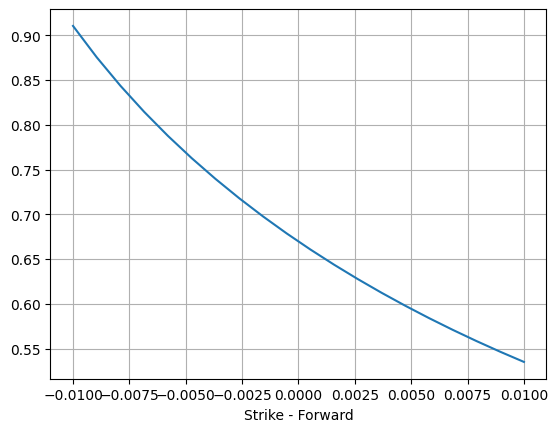

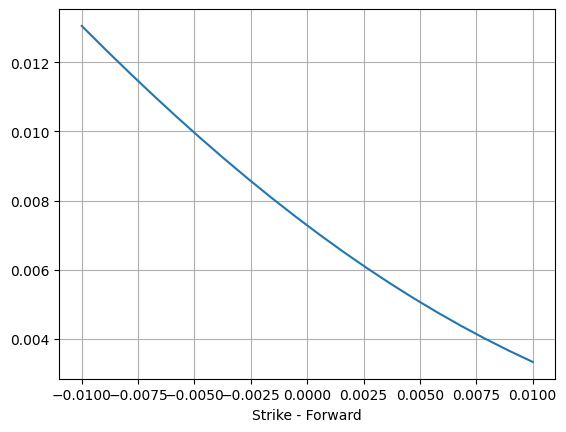

In [ ]:
class SABR():
    def __init__(self, sigma_0, beta, rho, volvol, K, r, q):
        self.sigma_0 = sigma_0
        self.beta = beta
        self.rho = rho
        self.volvol = volvol
        self.K = K
        self.r = r
        self.q = q

    def get_implied_vol(self, tt, price):
        """Convert SABR instantaneous vol to option implied vol

        Args:
            tt (np.ndarray): time to maturity in shape (num_period,)
            price (np.ndarray): underlying stock price in shape (num_path, num_period)

        Returns:
            np.ndarray: implied vol in shape (num_path, num_period)
        """
        return self._sabr_implied_vol(self.sigma_0 * np.ones_like(price), tt, price)
    def _sabr_implied_vol(self, vol, tt, price):
            """Convert SABR instantaneous vol to option implied vol

            Args:
                vol (np.ndarray): SABR instantaneous vol in shape (num_path, num_period)
                tt (np.ndarray): time to maturity in shape (num_period,)
                price (np.ndarray): underlying stock price in shape (num_path, num_period)

            Returns:
                np.ndarray: implied vol in shape (num_path, num_period)
            """
            F = price * np.exp((self.r - self.q) * tt)
            x = (F * self.K) ** ((1 - self.beta) / 2)
            y = (1 - self.beta) * np.log(F / self.K)
            A = vol / (x * (1 + y * y / 24 + y * y * y * y / 1920))
            B = 1 + tt * (
                    ((1 - self.beta) ** 2) * (vol * vol) / (24 * x * x)
                    + self.rho * self.beta * self.volvol * vol / (4 * x)
                    + self.volvol * self.volvol * (2 - 3 * self.rho * self.rho) / 24
            )
            Phi = (self.volvol * x / vol) * np.log(F / self.K)
            Chi = np.log((np.sqrt(1 - 2 * self.rho * Phi + Phi * Phi) + Phi - self.rho) / (1 - self.rho))

            SABRIV = np.where(F == self.K, vol * B / (F ** (1 - self.beta)), A * B * Phi / Chi)

            return SABRIV
iv_list = []
black_price_list = []
for k in np.linspace(0.01, 0.03, 20):
    iv = SABR(sigma_0=0.1, beta=0.5, rho=-0.77, volvol=0.5, K=k, r = 0, q=0).get_implied_vol(tt=2, price=np.array([0.02]))
    iv_list.append(iv)
    bp = black_price(F=0.02, K=k, sigma=iv, T=2, r=0, option_type="call")
    black_price_list.append(bp)
plt.plot(np.linspace(0.01, 0.03, 20)-0.02,iv_list)
plt.grid()
plt.xlabel("Strike - Forward")
#sigma_0, alpha, beta, rho =   get_sabr_params(1, 5, resolution=2, tau=0.5, rho_mat=rho_mat_0m_interpolated, theta_mat=theta_mat_0m_interpolated, phi_mat=phi_mat_0m_interpolated, lmm=lmm)
#plt.ylim(0.1,1)
plt.show()



plt.plot(np.linspace(0.01, 0.03, 20)-0.02,black_price_list)
plt.grid()
plt.xlabel("Strike - Forward")
plt.show()


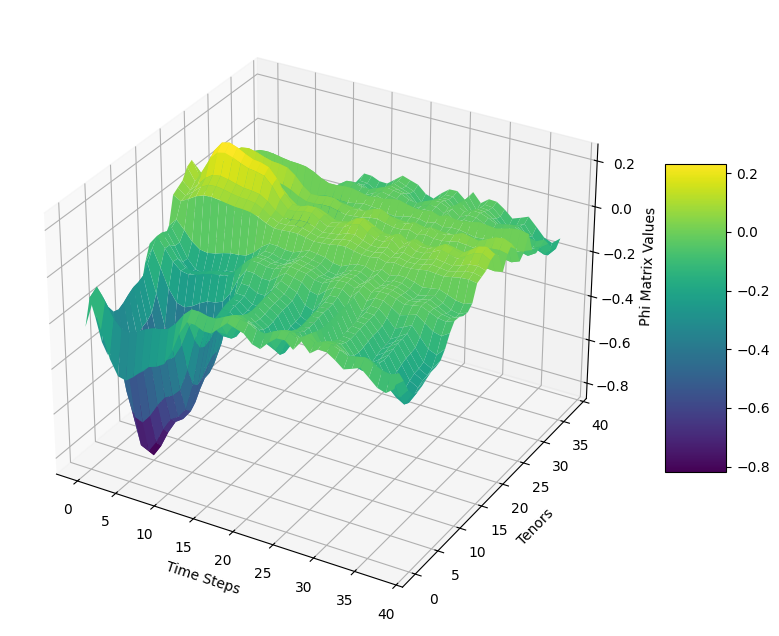

In [ ]:
import numpy as np

def build_phi_matrix(T, phi_diag, lambda3, lambda4):
    n = len(T)
    phi = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            Ti, Tj = T[i], T[j]
            phi_ii, phi_jj = phi_diag[i], phi_diag[j]
            A = np.sign(phi_ii) * np.sqrt(abs(phi_ii * phi_jj))
            decay = np.exp(-lambda3 * max(Ti - Tj, 0) - lambda4 * max(Tj - Ti, 0))
            phi[i, j] = A * decay

    return phi
T_arr = np.linspace(0, 9.5, 39)

# interpolate phi diag
phi_diag = np.diag(corr_fwd_vol)

phi_diag = np.concatenate([phi_diag[[0]],phi_diag])
T_phi = np.arange(0,10, 0.5)
interpolate_cubic = interpolate.CubicSpline(T_phi, phi_diag)

phi_interp = interpolate_cubic(T_arr)

phi_mat = build_phi_matrix(T_arr, phi_interp, 0.0087931, 0.051319)

# make 3d plot of phi_mat
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
X = np.arange(len(T_arr))
Y = np.arange(len(T_arr))
X, Y = np.meshgrid(X, Y)
Z = phi_mat
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Tenors')
ax.set_zlabel('Phi Matrix Values')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()


In [ ]:
def compute_Omega_ij(i, j, expiry, V, sigma_0, T, 
                     rho_mat, phi_mat, Ws, k0, g_func, h_func, ttm_mat):
    """
    Computes Omega_ij as in Equation (76).
    
    Parameters:
    - i, j: indices of the forward rates
    - expiry: expiry time T
    - V: vol-of-vol parameter
    - sigma_0: base volatility
    - T: expiry time (same as expiry_test)
    - rho_mat, phi_mat: correlation and theta matrices (shape: [n, n])
    - Ws: swap weights (shape: [n_expiry, n_swaplets])
    - k0: array of initial forward rate sensitivities (shape: [n])
    - g_func: function g(t), defined on the time grid
    - h_func: function h(t), defined on the time grid
    - ttm_mat: array of time-to-maturities (shape: [n])

    Returns:
    - Omega_ij (float)
    """

    T_i = ttm_mat[i]
    T_j = ttm_mat[j]

    def h_ij_squared(t):
        # RMS value of h_i(s) h_j(s) over [0, t]
        integrand = lambda s: h_func(T_i - s) * h_func(T_j - s)
        integral, _ = quad(integrand, 0, t, epsabs=1e-10)
        return (integral / t)

    def integrand(t):
        return g_func(T_i - t) * g_func(T_j - t) * h_ij_squared(t) * t

    integral, _ = quad(integrand, 0, T, epsabs=1e-10)

    numerator = (2 * rho_mat[i, j] * phi_mat[i, j] *
                 Ws[i] * Ws[j] * k0[i] * k0[j] * integral)

    denom = (V * sigma_0 * T) ** 2

    return numerator / denom




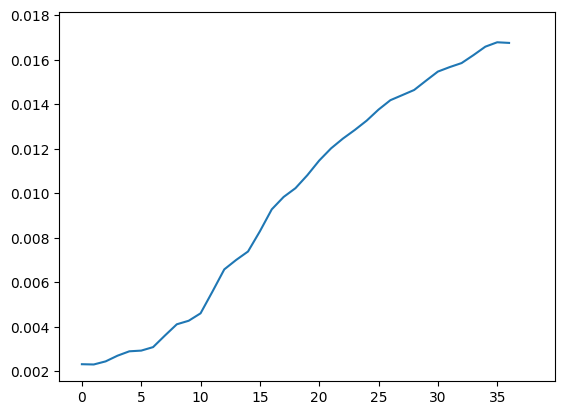

In [ ]:
fsim = lmm.f_sim[0]
plt.plot(fsim)

(103, 103, 2)
[[0.50030545 0.49969455]
 [0.50031527 0.49968473]
 [0.50032622 0.49967378]
 [0.50033733 0.49966267]
 [0.50034765 0.49965235]
 [0.5003562  0.4996438 ]
 [0.50036201 0.49963799]
 [0.50036459 0.49963541]
 [0.50036527 0.49963473]
 [0.50036588 0.49963412]
 [0.50036824 0.49963176]
 [0.50037416 0.49962584]
 [0.50038547 0.49961453]
 [0.50040327 0.49959673]
 [0.5004258  0.4995742 ]
 [0.50045058 0.49954942]
 [0.50047511 0.49952489]
 [0.5004969  0.4995031 ]
 [0.50051347 0.49948653]
 [0.50052329 0.49947671]
 [0.50052876 0.49947124]
 [0.50053327 0.49946673]
 [0.50054019 0.49945981]
 [0.50055293 0.49944707]
 [0.50057488 0.49942512]
 [0.50060819 0.49939181]
 [0.50065004 0.49934996]
 [0.50069635 0.49930365]
 [0.50074302 0.49925698]
 [0.50078597 0.49921403]
 [0.50082109 0.49917891]
 [0.50084558 0.49915442]
 [0.50086189 0.49913811]
 [0.50087381 0.49912619]
 [0.50088512 0.49911488]
 [0.50089962 0.49910038]
 [0.5009211  0.4990789 ]
 [0.50095221 0.49904779]
 [0.5009909  0.4990091 ]
 [0.5010339

/tmp/ipykernel_638050/2575214264.py:78: RuntimeWarning: invalid value encountered in divide
  W = swap_weights[None, :, :] * (fwd_subsets**beta) / (swaps_expanded**B)  # default: beta=0.5, B=0.5


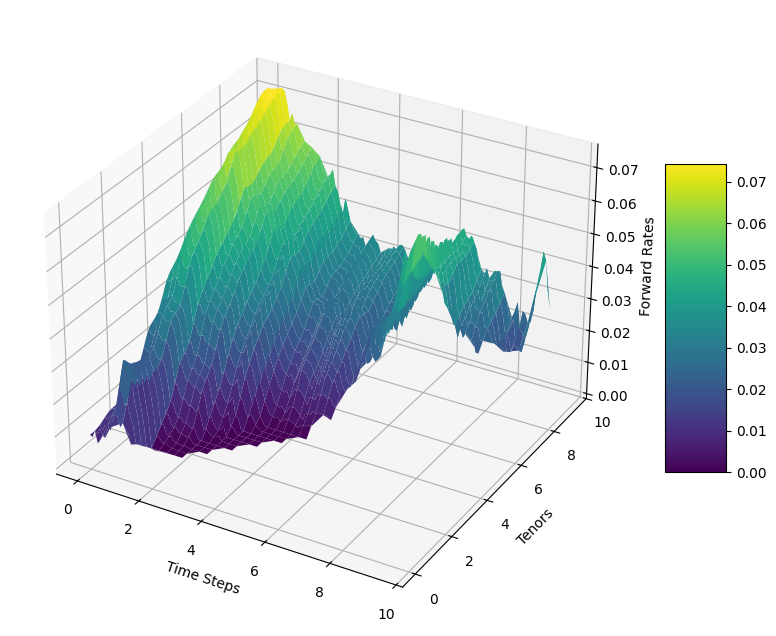

[[0.009 0.009 0.009 0.009 0.009 0.01  0.01  0.01  0.01  0.011 0.011 0.011 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.013 0.014 0.014 0.015 0.016 0.016 0.017 0.017 0.017 0.017 0.018 0.018 0.019 0.021 0.022 0.024 0.025 0.026 0.027 0.028 0.028 0.028 0.029 0.03  0.031 0.032 0.033 0.035 0.036 0.037 0.038 0.039 0.039 0.04  0.04  0.041 0.042 0.042 0.043 0.044 0.045 0.046 0.047 0.047 0.048 0.049 0.049 0.05  0.05  0.051 0.051 0.052 0.052 0.053 0.054 0.054 0.055 0.056 0.056 0.057 0.057 0.057 0.058 0.058 0.058 0.059 0.059 0.06  0.06  0.061 0.061 0.062 0.062 0.062 0.063 0.063 0.063 0.063 0.064 0.064 0.065 0.065 0.066 0.066 0.067 0.067 0.067 0.067 0.067 0.067   nan   nan   nan   nan   nan 0.07 ]
 [0.009 0.008 0.008 0.008 0.008 0.008 0.008 0.009 0.01  0.01  0.011 0.012 0.012 0.012 0.013 0.013 0.013 0.013 0.013 0.014 0.014 0.015 0.015 0.016 0.016 0.016 0.016 0.017 0.017 0.017 0.018 0.019 0.02  0.022 0.023 0.025 0.026 0.027 0.027 0.028 0.028 0.028 0.029 0.03  0.031 0.033 0.034 0.036 0.037 0.038 0.038

(array([[0.009, 0.009, 0.009, 0.009, 0.009, 0.01 , 0.01 , 0.01 , 0.01 , 0.011, 0.011, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.013, 0.014, 0.014, 0.015, 0.016, 0.016, 0.017, 0.017, 0.017, 0.017, 0.018, 0.018, 0.019, 0.021, 0.022, 0.024, 0.025, 0.026, 0.027, 0.028, 0.028, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.035, 0.036, 0.037, 0.038, 0.039, 0.039, 0.04 , 0.04 , 0.041, 0.042, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.047, 0.048, 0.049, 0.049, 0.05 , 0.05 , 0.051, 0.051, 0.052, 0.052, 0.053, 0.054, 0.054, 0.055, 0.056, 0.056, 0.057, 0.057, 0.057, 0.058, 0.058, 0.058, 0.059, 0.059, 0.06 , 0.06 , 0.061, 0.061, 0.062, 0.062, 0.062, 0.063, 0.063, 0.063, 0.063, 0.064, 0.064, 0.065, 0.065, 0.066, 0.066, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067,   nan,   nan,   nan,   nan,   nan, 0.07 ],
        [0.009, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.009, 0.01 , 0.01 , 0.011, 0.012, 0.012, 0.012, 0.013, 0.013, 0.013, 0.013, 0.013, 0.014, 0.014, 0.015, 0.015, 0.016, 0.016, 0

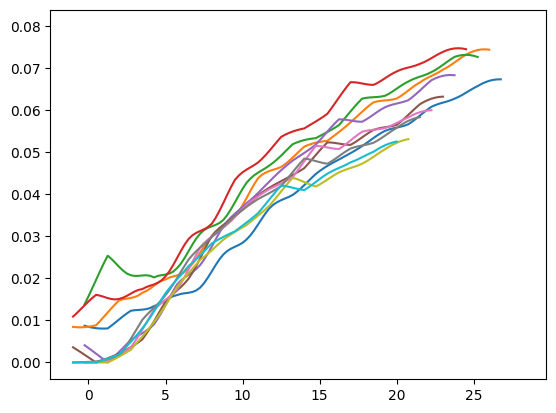

In [389]:

#for i in range(1000):
f_sim = lmm.simulate(resolution=6)
#print(lmm.tenors)
#print(lmm.h(0.1))

#print()
lmm.plot()

#plt.hist(lmm.f_sim[:,-1], bins=100)
lmm.f_sim
# print pretty formatted matrix
np.set_printoptions(precision=3, suppress=True)
# make matrix wider
np.set_printoptions(linewidth=2000)
# print full matrix, no shortening
np.set_printoptions(threshold=np.inf)
print(lmm.f_sim)
#print(np.hstack((lmm.time_grid.reshape(-1,1), 100*lmm.f_sim)))
for i in range(1,30, 3):
    print(lmm.f_sim[i].size)
    plt.plot((np.arange(lmm.f_sim[i].size)-i)*0.25, lmm.f_sim[i])
f_sim

In [ ]:

# Parameters

tau = 1
resolution = 2 / tau
num_forwards = 5 # including L(0,0,tau)



dt = tau / resolution
steps_per_year  = resolution * tau



# Tenor grid
ts_fwd_expiry = np.arange(num_forwards) * tau  # [0.0, 0.5, 1.0, ...]
ids_fwd_canon = (ts_fwd_expiry*resolution).astype(int)


# Time grid
T_max = ts_fwd_expiry[-1]
ts_fwd_expiry_interp = np.arange(0, T_max + dt, dt)  # [0.0, 0.25, ..., T_max]
assert ts_fwd_expiry_interp[-1] == T_max, "Time grid does not end at the beginning of the last forward"
ttm_matrix = ts_fwd_expiry_interp[None,:]-ts_fwd_expiry_interp[:,None] # each row is a time increment, and each column represents the time to maturity of a forward rate


In [ ]:
# pull out simulation, then do the swap stuff

In [ ]:
#define arguments to use for LMM SABR Simulation
no_of_sim = 2 #change this
steps_per_year = 20
F_0 = forwards #from caplet_fitting.py
s_0 = s0_exp #from caplet_fitting.py
epsilon = epsilon_exp #from caplet_fitting.py
corr_fwd_fwd_full_rank = doust_fwd_fwd[:19, :19]
corr_vol_vol_full_rank = doust_vol_vol[:19, :19]
corr_fwd_vol = corr_fwd_vol #from caplet_fitting.py
no_of_factors = 6 #correlation factors reduce rank
beta = np.repeat(0.5, len(F_0))
tau = 0.5 #semi-annual forwards
fixing_time_grid = np.arange(1,20)/2
print(fixing_time_grid)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.  9.5]


In [ ]:
simulated_fwd_full = simulateSABRLMM (no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                          fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                          epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                          corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                          corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                          beta = beta, tau = tau, params_g = params_g, params_h = params_h)

plt.plot(simulated_fwd_full[:,:,1].T)
plt.show()

NameError: name 'simulateSABRLMM' is not defined

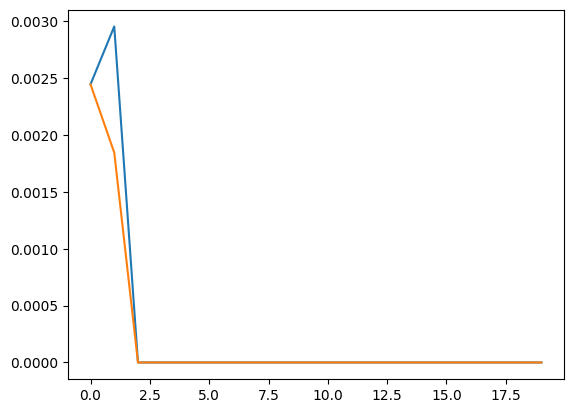

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

# Given function definitions
def g_tau(tau, a, b, c, d):
    """eq 2, also the function for sigma_i(tau_i)"""
    val = (a + b * tau) * np.exp(-c * tau) + d
    return np.maximum(val, 1e-6)

def h_tau(tau, ah, bh, gamma, delta):
    """eq 19, also the function for nu_i(tau_i) (volatility of volatility)"""
    val = (ah + bh * tau) * np.exp(-gamma * tau) + delta
    return np.maximum(val, 1e-6)

# Integral of g^2 over [0, T]
def g_hat(T, a, b, c, d):
    integral, _ = quad(lambda tau: g_tau(tau, a, b, c, d) ** 2, 0, T)
    return np.sqrt(integral / T)

# Integral of h^2 over [0, T]
def h_hat(T, ah, bh, gamma, delta):
    integral, _ = quad(lambda tau: h_tau(tau, ah, bh, gamma, delta) ** 2, 0, T)
    return np.sqrt(integral / T)




def initial_vol(rho_arr, W_arr, k_0_arr, g_tau_arr, T):
    """
    Computes the initial volatility Σ₀ using equation (63).

    Parameters:
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - T: (float) Maturity time T.

    Returns:
    - Σ₀: (float) The initial volatility term.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j dt
    integral_g = np.trapz(g_tau_arr @ g_tau_arr.T, dx=T / g_tau_arr.shape[1])
    
    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += rho_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_g[i, j]
    
    # Compute Σ₀
    Sigma_0 = np.sqrt((1 / T) * sum_term)
    
    return Sigma_0

initial_vol()

import numpy as np

def compute_V(Sigma_0, rho_arr, theta_arr, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, T):
    """
    Computes V using the given formula.

    Parameters:
    - Sigma_0: (float) Initial volatility term Σ₀.
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - theta_arr: (numpy array) Additional correlation matrix θ_ij.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - T: (float) Maturity time T.

    Returns:
    - V: (float) The computed volatility term V.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += 2 * rho_arr[i, j] * theta_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
    
    # Compute V
    V = (1 / (Sigma_0 * T)) * np.sqrt(sum_term)
    
    return V

import numpy as np

def compute_Omega(rho_mat, phi_mat, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, V, Sigma_0, T):
    """
    Computes Ω_ij using equation (76).

    Parameters:
    - rho_mat: (numpy array) Correlation matrix ρ_ij of forward rates.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - V: (float) Computed volatility term from equation (previous).
    - Sigma_0: (float) Initial volatility term.
    - T: (float) Maturity time.

    Returns:
    - Omega_mat: (numpy array) Matrix of Ω_ij values.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute Ω_ij matrix
    Omega_mat = np.zeros((no_of_fwds, no_of_fwds))
    denominator = (V * Sigma_0 * T) ** 2  # (V Σ₀ T)²
    
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            numerator = 2 * rho_mat[i, j] * theta_mat_0m[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
            Omega_mat[i, j] = numerator / denominator
    
    return Omega_mat


import numpy as np

def compute_Phi(Omega_mat, phi_mat, atol=1e-6):
    """
    Computes Φ using equation (78) and verifies Ω_ij constraints.

    Parameters:
    - Omega_mat: (numpy array) Weighting matrix Ω_ij.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - Phi: (float) The computed Φ value.
    """
    # Check that Ω_ij >= 0
    if np.any(Omega_mat < -atol):  # Allow small numerical noise
        raise ValueError("Error: Some elements in Omega_mat are negative!")

    # Check that sum of Ω_ij is close to 1
    Omega_sum = np.sum(Omega_mat)
    if not np.isclose(Omega_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of Ω_ij is {Omega_sum}, expected 1.0")

    # Compute Φ as the weighted sum of Ω_ij * φ_ij
    Phi = np.sum(Omega_mat * phi_mat)
    
    return Phi

import numpy as np

def compute_B(w_arr, beta_arr, atol=1e-6):
    """
    Computes B using equation (79), ensuring w_k acts as valid weights.

    Parameters:
    - w_arr: (numpy array) Weight vector w_k, corresponding to the swap periods.
    - beta_arr: (numpy array) Corresponding beta values β_k for each period.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - B: (float) The computed exponent B.
    """
    # Truncate arrays to match the running time of the swap
    w_arr = w_arr
    beta_arr = beta_arr

    # Ensure w_k are valid weights (sum to 1)
    w_sum = np.sum(w_arr)
    if not np.isclose(w_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of w_k is {w_sum}, expected 1.0")

    # Compute B as the weighted sum over the swap's running period
    B = np.sum(w_arr * beta_arr)
    
    return B

